# Movie Recommendation System

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import math
import seaborn as sns

In [2]:
ratings_df=pd.read_csv('combined_data_1.txt', names = ['user_id', 'rating', 'date'])
ratings_df.head()
# print(ratings_df.shape)

,user_id,rating,date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


Dataset Shape:  (24058263, 3)
Number of Movies: 4499
'5' Ratings: 5506583 percentage of total ratings 0.22892812118718717
'4' Ratings: 8085741 percentage of total ratings 0.33615283662049733
'3' Ratings: 6904181 percentage of total ratings 0.2870312105830921
'2' Ratings: 2439073 percentage of total ratings 0.10140088678013137
'1' Ratings: 1118186 percentage of total ratings 0.046486944829092026


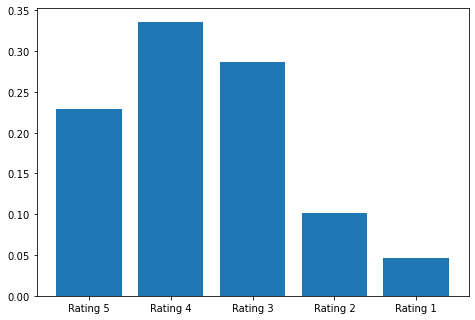

In [3]:
# exploratory analysis

print("Dataset Shape: ", ratings_df.shape)

rating_counts = ratings_df['rating'].value_counts(dropna = False)
print("Number of Movies:", rating_counts[np.nan])
print("'5' Ratings:", rating_counts[5], "percentage of total ratings",
      rating_counts[5]/(ratings_df.shape[0]-rating_counts[np.nan]))

print("'4' Ratings:", rating_counts[4], "percentage of total ratings",
      rating_counts[4]/(ratings_df.shape[0]-rating_counts[np.nan]))

print("'3' Ratings:", rating_counts[3], "percentage of total ratings",
      rating_counts[3]/(ratings_df.shape[0]-rating_counts[np.nan]))

print("'2' Ratings:", rating_counts[2], "percentage of total ratings",
      rating_counts[2]/(ratings_df.shape[0]-rating_counts[np.nan]))

print("'1' Ratings:", rating_counts[1], "percentage of total ratings",
      rating_counts[1]/(ratings_df.shape[0]-rating_counts[np.nan]))

fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
rating = ['Rating 5', 'Rating 4','Rating 3','Rating 2','Rating 1']
nums=[rating_counts[5]/(ratings_df.shape[0]-rating_counts[np.nan]),
     rating_counts[4]/(ratings_df.shape[0]-rating_counts[np.nan]),
     rating_counts[3]/(ratings_df.shape[0]-rating_counts[np.nan]),
     rating_counts[2]/(ratings_df.shape[0]-rating_counts[np.nan]),
     rating_counts[1]/(ratings_df.shape[0]-rating_counts[np.nan])]
ax.bar(rating,nums)
plt.show()

In [4]:
movies_id = []
user_id = ratings_df['user_id'].tolist()
ratings_list = ratings_df['rating'].tolist()
# when rating_list is null user_id will have the movie_id in the same column
for i in range(len(ratings_list)):
    if (pd.isnull(ratings_list[i])):
        movie_id = user_id[i][:-1]
        movies_id.append(-1)
    else:
        movies_id.append(int(movie_id))

# add movie_id to dataframe
ratings_df['movie_id'] = movies_id
ratings_df

,user_id,rating,date,movie_id
0,1:,NaN,NaN,-1
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499
24058259,1791000,2.0,2005-02-10,4499
24058260,512536,5.0,2005-07-27,4499
24058261,988963,3.0,2005-12-20,4499


In [5]:
# drop all rows with NaN values, original movie ids are no longer needed
ratings_df = ratings_df.dropna()
ratings_df

,user_id,rating,date,movie_id
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499
24058259,1791000,2.0,2005-02-10,4499
24058260,512536,5.0,2005-07-27,4499
24058261,988963,3.0,2005-12-20,4499


In [6]:
# read the movie names into a separate dataframe (found encoding attribute on stack overflow after a certain error)
movies_df = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", names = ['movie_id', 'year', 'movie_name'])
movies_df

,movie_id,year,movie_name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [7]:
# add movie_name to ratings df
movie_names = []
movie_ids = ratings_df['movie_id'].tolist()
for movie_id in movie_ids:
    movie_names.append(movies_df.at[movie_id - 1, 'movie_name'])
    

ratings_df['movie_name'] = movie_names
ratings_df

<ipython-input-7-58336e809a1f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['movie_name'] = movie_names


,user_id,rating,date,movie_id,movie_name
1,1488844,3.0,2005-09-06,1,Dinosaur Planet
2,822109,5.0,2005-05-13,1,Dinosaur Planet
3,885013,4.0,2005-10-19,1,Dinosaur Planet
4,30878,4.0,2005-12-26,1,Dinosaur Planet
5,823519,3.0,2004-05-03,1,Dinosaur Planet
...,...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499,In My Skin
24058259,1791000,2.0,2005-02-10,4499,In My Skin
24058260,512536,5.0,2005-07-27,4499,In My Skin
24058261,988963,3.0,2005-12-20,4499,In My Skin


In [8]:
ratings_df=ratings_df.drop('date', 1)
ratings_df

,user_id,rating,movie_id,movie_name
1,1488844,3.0,1,Dinosaur Planet
2,822109,5.0,1,Dinosaur Planet
3,885013,4.0,1,Dinosaur Planet
4,30878,4.0,1,Dinosaur Planet
5,823519,3.0,1,Dinosaur Planet
...,...,...,...,...
24058258,2591364,2.0,4499,In My Skin
24058259,1791000,2.0,4499,In My Skin
24058260,512536,5.0,4499,In My Skin
24058261,988963,3.0,4499,In My Skin


In [9]:
ratings_df = ratings_df.dropna()
ratings_df

,user_id,rating,movie_id,movie_name
1,1488844,3.0,1,Dinosaur Planet
2,822109,5.0,1,Dinosaur Planet
3,885013,4.0,1,Dinosaur Planet
4,30878,4.0,1,Dinosaur Planet
5,823519,3.0,1,Dinosaur Planet
...,...,...,...,...
24058258,2591364,2.0,4499,In My Skin
24058259,1791000,2.0,4499,In My Skin
24058260,512536,5.0,4499,In My Skin
24058261,988963,3.0,4499,In My Skin


In [10]:
x = ratings_df.movie_name.unique()
print("The number of unique movies in the dataframe: ", len(x))

The number of unique movies in the dataframe:  4471


In [11]:
ratings_df['movie_popularity'] = ratings_df['movie_name'].map(ratings_df['movie_name'].value_counts())
ratings_df

,user_id,rating,movie_id,movie_name,movie_popularity
1,1488844,3.0,1,Dinosaur Planet,547
2,822109,5.0,1,Dinosaur Planet,547
3,885013,4.0,1,Dinosaur Planet,547
4,30878,4.0,1,Dinosaur Planet,547
5,823519,3.0,1,Dinosaur Planet,547
...,...,...,...,...,...
24058258,2591364,2.0,4499,In My Skin,428
24058259,1791000,2.0,4499,In My Skin,428
24058260,512536,5.0,4499,In My Skin,428
24058261,988963,3.0,4499,In My Skin,428


In [16]:
temp_df = pd.value_counts(ratings_df.movie_name).to_frame().reset_index()
temp_df

,index,movie_name
0,Pirates of the Caribbean: The Curse of the Bla...,193941
1,What Women Want,162597
2,Bruce Almighty,160454
3,The Italian Job,156183
4,American Beauty,154832
...,...,...
443,Halloween II,11810
444,Friday After Next,11620
445,The Lawnmower Man,11548
446,Simone,11534


In [17]:
print("The average movie popularity is: ", temp_df['movie_name'].mean())
temp_df['percentile']=temp_df.movie_name.rank(pct=True)
temp_df = temp_df[temp_df['percentile'] >= 0.93] 
temp_df

The average movie popularity is:  41177.94866071428


,index,movie_name,percentile
0,Pirates of the Caribbean: The Curse of the Bla...,193941,1.000000
1,What Women Want,162597,0.997768
2,Bruce Almighty,160454,0.995536
3,The Italian Job,156183,0.993304
4,American Beauty,154832,0.991071
5,Shrek 2,153996,0.988839
6,The Sixth Sense,151292,0.986607
7,Lord of the Rings: The Fellowship of the Ring,149866,0.984375
8,50 First Dates,145519,0.982143
9,Finding Nemo (Widescreen),140979,0.979911


In [18]:
min_mv = temp_df['movie_name'].min()
print("The minimum value of movie popularity for the most rated movies is: ", min_mv)

The minimum value of movie popularity for the most rated movies is:  106807


In [19]:
ratings_df = ratings_df[ratings_df['movie_popularity'] >= min_mv]
ratings_df

,user_id,rating,movie_id,movie_name,movie_popularity
92828,2173336,5.0,30,Something's Gotta Give,118413
92829,2473170,5.0,30,Something's Gotta Give,118413
92830,900816,3.0,30,Something's Gotta Give,118413
92831,1990901,4.0,30,Something's Gotta Give,118413
92832,662337,4.0,30,Something's Gotta Give,118413
...,...,...,...,...,...
23805584,158902,5.0,4432,The Italian Job,156183
23805585,1487867,5.0,4432,The Italian Job,156183
23805586,1595055,5.0,4432,The Italian Job,156183
23805587,2310454,2.0,4432,The Italian Job,156183


In [28]:
from numpy import count_nonzero
mat_df = ratings_df.pivot_table(index='user_id',columns='movie_name',values='rating').fillna(0)
np_mat = mat_df.values
print(type(mat_df))
print(type(np_mat))

#sparsity calculation
sparsity = 1 - (count_nonzero(np_mat)/float(np_mat.size))
print("sparsity: ", sparsity)

mat_df.head(10)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
sparsity:  0.6917671785956994


movie_name,50 First Dates,A Beautiful Mind,American Beauty,Braveheart,Bruce Almighty,Eternal Sunshine of the Spotless Mind,Finding Nemo (Widescreen),Finding Neverland,Ghost,Kill Bill: Vol. 2,...,Something's Gotta Give,The Bourne Supremacy,The Italian Job,The Last Samurai,The Matrix: Reloaded,The Recruit,The Silence of the Lambs,The Sixth Sense,The Wedding Planner,What Women Want
user_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,3.0,4.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,4.0
1000027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
1000033,4.0,0.0,5.0,0.0,3.0,3.0,5.0,4.0,2.0,0.0,...,4.0,4.0,5.0,0.0,4.0,0.0,0.0,0.0,3.0,4.0
1000035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
100006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000062,0.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,0.0,...,3.0,4.0,3.0,3.0,5.0,0.0,3.0,5.0,0.0,4.0
100007,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0


In [34]:
#we will convert this dataframe to a sparse matrix, because, most of the values in the matrix are 0s
#this will only look at non-zero values, as that would imply some rating is present for that specific user and rating
movies_sm = csr_matrix(np_mat)
print(movies_sm)

  (0, 1)	3.0
  (0, 2)	4.0
  (0, 3)	4.0
  (0, 6)	5.0
  (0, 16)	5.0
  (0, 17)	3.0
  (0, 20)	3.0
  (0, 21)	5.0
  (0, 29)	5.0
  (0, 30)	3.0
  (0, 31)	4.0
  (1, 8)	5.0
  (1, 10)	5.0
  (1, 12)	5.0
  (1, 13)	5.0
  (1, 18)	5.0
  (1, 29)	5.0
  (2, 0)	4.0
  (2, 2)	5.0
  (2, 4)	3.0
  (2, 5)	3.0
  (2, 6)	5.0
  (2, 7)	4.0
  (2, 8)	2.0
  (2, 10)	3.0
  :	:
  (431143, 24)	3.0
  (431143, 28)	3.0
  (431144, 8)	4.0
  (431144, 16)	1.0
  (431144, 21)	4.0
  (431144, 27)	4.0
  (431144, 29)	4.0
  (431145, 0)	5.0
  (431145, 1)	3.0
  (431145, 8)	3.0
  (431145, 9)	5.0
  (431145, 10)	4.0
  (431145, 11)	5.0
  (431145, 13)	2.0
  (431145, 16)	5.0
  (431145, 21)	3.0
  (431145, 24)	3.0
  (431145, 26)	5.0
  (431145, 29)	5.0
  (431145, 31)	2.0
  (431146, 8)	4.0
  (431146, 13)	2.0
  (431146, 22)	3.0
  (431146, 25)	4.0
  (431146, 26)	4.0


In [41]:
movies_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
movies_knn.fit(movies_sm)

NearestNeighbors(algorithm='brute', metric='cosine')